# Investigate the floating point error for combined functions

Let's look at the function $f(x) = \frac{\sin(x)}{x}$ which has the following Taylor series:

$$
f_n(x) = \sum_{i=0}^{n}\frac{(-1)^i x^{2i}}{(2i + 1)!} = 1 - \frac{x^2}{6} + \frac{x^4}{120} - \frac{x^6}{5040} + \;...
$$

In the following we will compare the original representation $f(x) = \frac{\sin(x)}{x}$ against the series expansion, truncated at various orders.

In [1]:
from pprint import pprint
from math import factorial
import numpy as np

x_range = np.logspace(-10, 0, 50)

N = 8
series_coef = [0.] * (2*N - 1)
series_coef[::2] = [(-1)**i / factorial(2*i + 1) for i in range(N)]
series = [np.poly1d(series_coef[2*i::-1]) for i in range(1, N)]

pprint(series)

[poly1d([-0.16666667,  0.        ,  1.        ]),
 poly1d([ 0.00833333,  0.        , -0.16666667,  0.        ,  1.        ]),
 poly1d([-1.98412698e-04,  0.00000000e+00,  8.33333333e-03,  0.00000000e+00,
       -1.66666667e-01,  0.00000000e+00,  1.00000000e+00]),
 poly1d([ 2.75573192e-06,  0.00000000e+00, -1.98412698e-04,  0.00000000e+00,
        8.33333333e-03,  0.00000000e+00, -1.66666667e-01,  0.00000000e+00,
        1.00000000e+00]),
 poly1d([-2.50521084e-08,  0.00000000e+00,  2.75573192e-06,  0.00000000e+00,
       -1.98412698e-04,  0.00000000e+00,  8.33333333e-03,  0.00000000e+00,
       -1.66666667e-01,  0.00000000e+00,  1.00000000e+00]),
 poly1d([ 1.60590438e-10,  0.00000000e+00, -2.50521084e-08,  0.00000000e+00,
        2.75573192e-06,  0.00000000e+00, -1.98412698e-04,  0.00000000e+00,
        8.33333333e-03,  0.00000000e+00, -1.66666667e-01,  0.00000000e+00,
        1.00000000e+00]),
 poly1d([-7.64716373e-13,  0.00000000e+00,  1.60590438e-10,  0.00000000e+00,
       -2.5052108

For the reference values we use the arbitrary precision floating point math library `mpmath`:

In [2]:
import mpmath as mp

mp.mp.dps = 1000  # 1,000 significant decimal places (64-bit float has about 16 dps)
ref = [mp.sin(x)/x for z in x_range for x in (mp.mpf(z),)]

print(ref[0])

0.99999999999999999999833333333333333321189350894834085919072794818170541524702469371552280028226453267917588882334009360340559196746659630393007243965049115981477485708600354325031650488009925341050596194590529763870069900354702897733641649319266991528166078840679515985507911230430153175105928483229947609328359444433527704652771012362178487923429970794109020880851892466303543831913441862786903901875910680301394946118184464961809581671343667337165555012387950426705472691978443534308201738555791014703355625051064471058491423784606551378571585319211454579598064135327221322538240578927795557515980640121296791203588586682468222057764758693117508246532192184749273911690389363816317991502137709915450571503987047673313817823685219591987142333497159302558386546842466343804033133283380526565234884371322750126315708455713708223524435302479832041481166207933684435274150690068465588963722100864905093125509838808160475576602066510601527097968694256395360202134578328885963284331198459209444982287614

In [3]:
x = x_range
r_orig = np.sin(x) / x
r_series = [s(x) for s in series]

Let's compute the errors w.r.t. the reference data and check for which values of $x$ the original version has a smaller floating point error than the series expansion(s):

In [4]:
err_orig = np.array([abs(a - b) for a, b in zip(r_orig, ref)])
err_series = np.array([[abs(a - b) for a, b in zip(rs, ref)] for rs in r_series])

better = err_orig < err_series
similar = err_orig == err_series
worse = err_orig > err_series

difference = np.abs((err_orig - err_series).astype(float))

pprint([(d[w].min(), d[w].max()) for d, w in zip(difference, worse)])

[(2.182456214206085e-17, 1.1102230246251565e-16),
 (2.8459390635531962e-18, 1.1102230246251565e-16),
 (2.8459390635531962e-18, 1.1102230246251565e-16),
 (2.8459390635531962e-18, 1.1102230246251565e-16),
 (2.8459390635531962e-18, 1.1102230246251565e-16),
 (2.8459390635531962e-18, 1.1102230246251565e-16),
 (2.8459390635531962e-18, 1.1102230246251565e-16)]


The maximum error is half the floating point epsilon:

In [5]:
import sys
print(sys.float_info.epsilon / 2)

1.1102230246251565e-16


Let's plot the results:

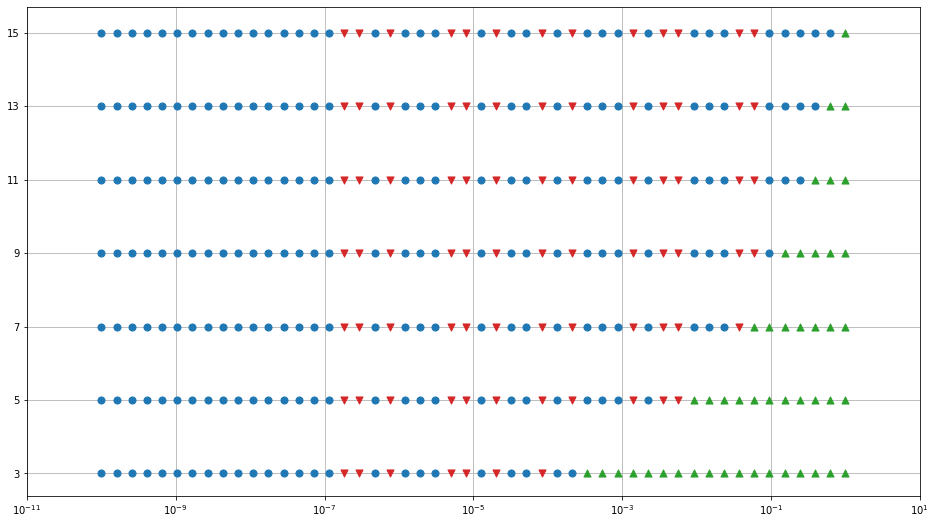

In [7]:
import matplotlib.pyplot as plt

y_data = [np.repeat(len(s.coef), len(x_range)) for s in series]

f, ax = plt.subplots(figsize=(16, 9))
for y, b, s, w in zip(y_data, better, similar, worse):
    ax.scatter(x_range[b], y[b], s=50, marker='^', c='#2ca02c')  # green
    ax.scatter(x_range[s], y[s], s=50, marker='o', c='#1f77b4')  # blue
    ax.scatter(x_range[w], y[w], s=50, marker='v', c='#d62728')  # red
ax.set_xlim([x_range.min()/10, x_range.max()*10])
ax.set_xscale('log')
ax.set_yticks([y[0] for y in y_data])
ax.grid(which='both')
ax.set_axisbelow(True)